# Librairies

In [3]:
# basics
import numpy as np
import pandas as pd
import os 
import gc
import csv
import time
import ast
import random
from contextlib import contextmanager
import pprint
import itertools

# preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# model selection / metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import RocCurveDisplay

# model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

# dataviz
import matplotlib.pyplot as plt
import seaborn as sns

# ML Flow
import mlflow
from mlflow.models import infer_signature
import joblib

# SHAP
import shap
shap.initjs()

# warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Preprocessing Data : Functions

## Encoding

In [4]:
def encodeur(X) : 
    print("Tailles des données avant encodage des variables catégorielles :", X.shape)

    # copy numerical features from data
    X_enc = X.select_dtypes(include=np.number) 
    
    # add new features from the encoding of multi_class features : one-hot encoding
    multi_class_cols = [col for col in X.select_dtypes(include=[object]) if X[col].nunique() > 2]
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    ohe.fit(X[multi_class_cols])
    df_multi = pd.DataFrame(ohe.transform(X[multi_class_cols]), columns = ohe.get_feature_names_out(), index=X.index)
    X_enc = pd.concat([X_enc, df_multi], axis=1) 
    
    # add new features from the encoding of binary_class features : label encoding
    bi_class_cols = [col for col in X.select_dtypes(include=[object]) if X[col].nunique() <= 2]
    oe = OrdinalEncoder()
    oe.fit(X[bi_class_cols])
    df_binary = pd.DataFrame(oe.transform(X[bi_class_cols]), columns = oe.feature_names_in_, index=X.index)
    X_enc = pd.concat([X_enc, df_binary], axis=1) # add multi_class features
  
    print("Tailles des données après encodage des variables catégorielles :", X_enc.shape)
    return X_enc

## Exploring

In [5]:
def explorer(dataframe):
    # Information sur les valeurs nulle
    plt.figure(figsize = (5, 4))
    plt.hist(x = dataframe.isnull().mean(), color = 'navy', bins = 10)
    plt.title('Distribution des colonnes selon leur taux de valeurs nulles', fontsize = 10)
    plt.xlabel('taux de valeurs nulles', fontsize = 9)
    plt.ylabel('nb de colonnes', fontsize = 9)
    plt.grid(visible=True)
    plt.show()

    # Information sur les types de données
    type_counts = dataframe.dtypes.value_counts()
    fig, ax = plt.subplots(figsize=(5, 2))
    bars = ax.barh(y = type_counts.index.astype(str), width = type_counts.values, height = 0.5, color = 'navy')
    ax.bar_label(bars, fontsize = 9)
    ax.get_xaxis().set_visible(False)
    plt.yticks(fontsize = 9)
    plt.title('Nb de colonnes par type de données', fontsize = 10)
    plt.show()
    
    # Information sur les variables catégorielles
    class_counts = dataframe.select_dtypes(include=[object]).nunique().value_counts()
    plt.figure(figsize = (5, 4))
    plt.bar(x = class_counts.index, height=class_counts.values, color = 'navy')
    plt.title('Distribution des colonnes catégorielles selon leur nombre de classes', fontsize = 10)
    plt.xlabel('nb de classes', fontsize = 9)
    plt.ylabel('nb de colonnes', fontsize = 9)
    plt.grid(visible=True)
    plt.show()

## Autres fonctions

In [6]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - Traité en {:.0f}s".format(title, time.time() - t0))

In [7]:
def shape_printer(title, df):
    print("{} - Tailles des données chargées : {}".format(title, df.shape))

In [8]:
def aligner(X, Y):
    # Aligne les colonnes de X sur celles de Y : renvoit une version de X avec des colonnes ajoutées/supprimées.
    X_aligned = X.copy()
    
    # colonnes en moins
    missing_in_X = [feat for feat in Y if feat not in X]
    added_columns = pd.DataFrame(np.zeros((X.shape[0], len(missing_in_X))), columns = missing_in_X, index=X.index)
    X_aligned = pd.concat([X_aligned, added_columns], axis=1)

    # colonnes en trop
    missing_in_Y = [feat for feat in X if feat not in Y]
    for feat in missing_in_Y : X_aligned.pop(feat)

    return X_aligned

## Loading

In [9]:
path_to_files = "../data/kaggle/"

In [10]:
# List files available
print(os.listdir(path_to_files))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


### application_train and test.csv (main files)

In [11]:
def main_file(train_or_test='train', num_rows = None):
    df = pd.read_csv(path_to_files + 'application_' + train_or_test + '.csv', nrows = num_rows)
    print("Tailles des données d'origine :", df.shape)

    # Replace the anomalous values with nan
    df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
    
    # remove infinity values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    print("Tailles des données avec features ajoutées :", df.shape)

    return df

Les fonctions ci-dessous ont été reprises du kernel Kaggle "LightGBM with Simple Features" partagé by Aguiar.

In [12]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

### bureau.csv and bureau_balance.sv

In [13]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(df_sk_id, num_rows = None, nan_as_category = True):

    bureau = pd.read_csv(path_to_files+'bureau.csv', nrows = num_rows)
    bb = pd.read_csv(path_to_files+'bureau_balance.csv', nrows = num_rows)

    # Keep only SK_ID provided in the function parameters (used for train/test split)
    bureau = bureau.merge(df_sk_id, how='inner', on='SK_ID_CURR')
    bb = bb.merge(bureau[['SK_ID_BUREAU']], how='inner', on='SK_ID_BUREAU')

    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()

    shape_printer("bureau.csv & bureau_balance.csv", bureau_agg)
    return bureau_agg

### previous_applications.csv

In [14]:
def previous_applications(df_sk_id, num_rows = None, nan_as_category = True):
    prev = pd.read_csv(path_to_files+'previous_application.csv', nrows = num_rows)
    
    # Keep only SK_ID provided in the function parameters (used for train/test split)
    prev = prev.merge(df_sk_id, how='inner', on='SK_ID_CURR')
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    
    #Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    shape_printer("previous_applications.csv", prev_agg)
    return prev_agg

### POS_CASH_balance.csv

In [15]:
# Preprocess POS_CASH_balance.csv
def pos_cash(df_sk_id, num_rows = None, nan_as_category = True):
    pos = pd.read_csv(path_to_files+'POS_CASH_balance.csv', nrows = num_rows)
    
    # Keep only SK_ID provided in the function parameters (used for train/test split)
    pos = pos.merge(df_sk_id, how='inner', on='SK_ID_CURR')
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    shape_printer("POS_CASH_balance.csv", pos_agg)
    return pos_agg

### installments_payments.csv

In [16]:
# Preprocess installments_payments.csv
def installments_payments(df_sk_id, num_rows = None, nan_as_category = True):
    ins = pd.read_csv(path_to_files+'installments_payments.csv', nrows = num_rows)
    
    # Keep only SK_ID provided in the function parameters (used for train/test split)
    ins = ins.merge(df_sk_id, how='inner', on='SK_ID_CURR')
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    shape_printer("installments_payments.csv", ins_agg)
    return ins_agg

### credit_card_balance.csv

In [17]:
# Preprocess credit_card_balance.csv
def credit_card_balance(df_sk_id, num_rows = None, nan_as_category = True):
    cc = pd.read_csv(path_to_files+'credit_card_balance.csv', nrows = num_rows)
    # Keep only SK_ID provided in the function parameters (used for train/test split)
    cc = cc.merge(df_sk_id, how='inner', on='SK_ID_CURR')
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

    # convert boolean columns to numeric values
    boolean_cols = [col for col in cc_agg.select_dtypes(include=[bool])]
    for c in boolean_cols : cc_agg[c] = cc_agg[c].astype(int)
    
    del cc
    gc.collect()
    shape_printer("credit_card_balance.csv", cc_agg)
    return cc_agg

### All secondary files

In [18]:
def add_variables(X):
    print("Tailles des données avant enrichissement :", X.shape)
    print("------------------------------------------")
    
    sk_id = X[['SK_ID_CURR']]
    with timer("bureau.csv & bureau_balance.csv"):
        bureau = bureau_and_balance(sk_id)
        X = X.join(bureau, how='left', on='SK_ID_CURR')
    
    with timer("previous_applications"):
        previous = previous_applications(sk_id)
        X = X.join(previous, how='left', on='SK_ID_CURR')
    
    with timer("POS_CASH_balance.csv"):
        pos = pos_cash(sk_id)
        X = X.join(pos, how='left', on='SK_ID_CURR')
    
    with timer("installments_payments.csv"):
        installments = installments_payments(sk_id)
        X = X.join(installments, how='left', on='SK_ID_CURR')
    
    with timer("credit_card_balance.csv"):
        credit = credit_card_balance(sk_id)
        X = X.join(credit, how='left', on='SK_ID_CURR')
    
    # remove infinity values
    X.replace([np.inf, -np.inf], np.nan, inplace=True)

    print("------------------------------------------")
    print("Tailles des données après enrichissement :", X.shape)

    return X

# Preprocessing Data : Assembling

## Load main file (application.csv)

In [19]:
nombre_de_lignes = 10000 # None # 100000
app_kaggle_train = main_file('train', nombre_de_lignes)

Tailles des données d'origine : (10000, 122)
Tailles des données avec features ajoutées : (10000, 127)


In [20]:
app_kaggle_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,1.0,0.067329,0.498036,202500.0,0.121978,0.060749
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.070862,0.208736,135000.0,0.132217,0.027598
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.011814,0.500000,67500.0,0.100000,0.050000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,0.159905,0.431748,67500.0,0.219900,0.094941
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.152418,0.236842,121500.0,0.179963,0.042623


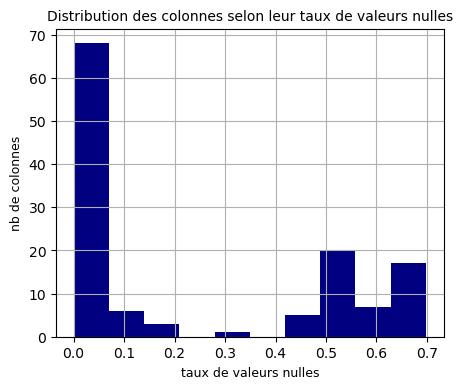

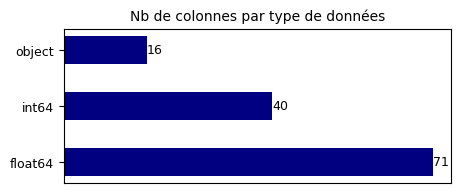

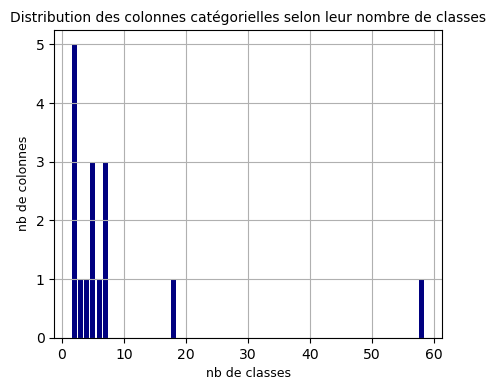

In [21]:
explorer(app_kaggle_train)

## Train/Test Split

In [22]:
X_kaggle_train = app_kaggle_train.drop(columns = 'TARGET')
y_kaggle_train = app_kaggle_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X_kaggle_train, y_kaggle_train, test_size = 0.25, random_state = 1209)
print(f"X_train : {X_train.shape} et y_train : {y_train.shape}")
print(f"X_test : {X_test.shape} et y_test : {y_test.shape}")

X_train : (7500, 126) et y_train : (7500,)
X_test : (2500, 126) et y_test : (2500,)


In [23]:
X_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
5213,106099,Cash loans,F,N,Y,1,76500.0,675000.0,19867.5,675000.0,...,0.0,0.0,0.0,0.0,2.0,NaN,0.113333,25500.0,0.259706,0.029433
3090,103607,Cash loans,F,N,N,0,67500.0,781920.0,25969.5,675000.0,...,NaN,NaN,NaN,NaN,NaN,0.343204,0.086326,33750.0,0.384733,0.033212
631,100721,Cash loans,F,Y,Y,1,216000.0,868500.0,25393.5,868500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.248705,72000.0,0.117563,0.029238
7843,109146,Cash loans,F,Y,Y,0,112500.0,675000.0,20596.5,675000.0,...,NaN,NaN,NaN,NaN,NaN,0.268398,0.166667,112500.0,0.183080,0.030513
2240,102627,Cash loans,F,N,Y,0,351000.0,2085120.0,72607.5,1800000.0,...,0.0,0.0,0.0,0.0,2.0,0.039756,0.168336,175500.0,0.206859,0.034822


In [24]:
y_train.head()

5213    0
3090    0
631     0
7843    0
2240    0
Name: TARGET, dtype: int64

## Assembling Training Data

In [25]:
# Encodage
X_train_enc = encodeur(X_train)
X_train_enc.head()

Tailles des données avant encodage des variables catégorielles : (7500, 126)
Tailles des données après encodage des variables catégorielles : (7500, 243)


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,EMERGENCYSTATE_MODE
5213,106099,1,76500.0,675000.0,19867.5,675000.0,0.019689,-21955,NaN,-1479.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3090,103607,0,67500.0,781920.0,25969.5,675000.0,0.035792,-17054,-5853.0,-9954.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN
631,100721,1,216000.0,868500.0,25393.5,868500.0,0.014520,-19605,NaN,-6693.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN
7843,109146,0,112500.0,675000.0,20596.5,675000.0,0.022800,-19404,-5208.0,-5082.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN
2240,102627,0,351000.0,2085120.0,72607.5,1800000.0,0.020713,-10665,-424.0,-966.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [26]:
## Add features from secondary files
X_train_enc = add_variables(X_train_enc)
X_train_enc.sort_index(axis=1, inplace=True)

Tailles des données avant enrichissement : (7500, 243)
------------------------------------------
bureau.csv & bureau_balance.csv - Tailles des données chargées : (6427, 108)
bureau.csv & bureau_balance.csv - Traité en 7s
previous_applications.csv - Tailles des données chargées : (7147, 244)
previous_applications - Traité en 5s
POS_CASH_balance.csv - Tailles des données chargées : (7115, 17)
POS_CASH_balance.csv - Traité en 5s
installments_payments.csv - Tailles des données chargées : (7159, 26)
installments_payments.csv - Traité en 8s
credit_card_balance.csv - Tailles des données chargées : (2111, 131)
credit_card_balance.csv - Traité en 5s
------------------------------------------
Tailles des données après enrichissement : (7500, 769)


In [27]:
# Check if data is balanced
y_train.value_counts()

TARGET
0    6913
1     587
Name: count, dtype: int64

## Assembling Test Data

In [28]:
# Encodage
X_test_enc = encodeur(X_test)

Tailles des données avant encodage des variables catégorielles : (2500, 126)
Tailles des données après encodage des variables catégorielles : (2500, 241)


In [29]:
## Add features from secondary files
X_test_enc = add_variables(X_test_enc)

Tailles des données avant enrichissement : (2500, 241)
------------------------------------------
bureau.csv & bureau_balance.csv - Tailles des données chargées : (2133, 107)
bureau.csv & bureau_balance.csv - Traité en 7s
previous_applications.csv - Tailles des données chargées : (2368, 240)
previous_applications - Traité en 5s
POS_CASH_balance.csv - Tailles des données chargées : (2350, 16)
POS_CASH_balance.csv - Traité en 5s
installments_payments.csv - Tailles des données chargées : (2373, 26)
installments_payments.csv - Traité en 8s
credit_card_balance.csv - Tailles des données chargées : (686, 126)
credit_card_balance.csv - Traité en 5s
------------------------------------------
Tailles des données après enrichissement : (2500, 756)


In [30]:
# Check if data is balanced
y_test.value_counts()

TARGET
0    2312
1     188
Name: count, dtype: int64

In [31]:
# Alignement des colonnes de X_test sur X_train
X_test_enc = aligner(X_test_enc, X_train_enc)
X_test_enc.sort_index(axis=1, inplace=True)
X_test_enc.shape

(2500, 769)

# Modélisation

In [32]:
def bank_loss_func(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    bank_loss = 10*fn + fp # un crédit accordé non remboursé est évalué à un montant 10 fois plus élevé qu'un crédit solvable non accordé
    return bank_loss

In [33]:
bank_score = make_scorer(bank_loss_func, greater_is_better=False)

## Déséquilibrage des valeurs cibles

In [34]:
# retrait des NaN
imputer = SimpleImputer(strategy = 'median').set_output(transform="pandas")
X_train_imp = imputer.fit_transform(X_train_enc)

# oversampling customers with y=1 : with smote
smote_sampling_strategy = 0.15
over = SMOTE(sampling_strategy=smote_sampling_strategy, k_neighbors=5, random_state=1209)
X_train_over, y_train_over = over.fit_resample(X_train_imp, y_train)

# undersampling customers with y=0
undersampling_strategy = 0.33
under = RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=1209)
X_train_bal, y_train_bal = under.fit_resample(X_train_over, y_train_over)

print("Répartition des valeurs 'y' après rééquilibrage :")
print(y_train_bal.value_counts())

Répartition des valeurs 'y' après rééquilibrage :
TARGET
0    3139
1    1036
Name: count, dtype: int64


## Modèle de base : régression logistique

In [35]:
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty='l2', class_weight='balanced', C=0.1, max_iter=1000))]
)

### Entraînement du modèle

#### Optimisation des paramètres

In [36]:
# grille de paramètres
# param_grid = {'clf__C' : np.logspace(-2, 1, 4)} # Inverse of regularization strength -> best = 0.1
lr_grid = {'clf__C' : [0.1]}

# initialiser la validation croisée
lr_search = GridSearchCV(pipe, lr_grid, cv=5, scoring=bank_score)

# On entraîne ce modèle sur les données d'entrainement
lr_search.fit(X_train_bal, y_train_bal)

# On extrait la meilleure combinaison de paramètres
res = pd.DataFrame(lr_search.cv_results_)[['param_clf__C', 'mean_test_score', 'std_test_score', 'rank_test_score', 'mean_fit_time']]
res.sort_values('rank_test_score').head(10)

,param_clf__C,mean_test_score,std_test_score,rank_test_score,mean_fit_time
0,0.1,-651.6,194.233468,1,0.502991


#### Fit

In [37]:
# Le modèle est entraîné sur les données équilibrées
pipe.set_params(**lr_search.best_params_).fit(X_train_bal, y_train_bal)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000))])

#### Optimisation du seuil

In [38]:
def custom_threshold_func(y_true, y_proba) :
    best_threshold = 0.5
    y_pred = (y_proba > 0.5).astype(int)
    lower_loss = bank_loss_func(y_true, y_pred) 
    for threshold in range(100) :
        y_thresh = (y_proba > (threshold/100)).astype(int)
        loss = bank_loss_func(y_true, y_thresh) 
        #print(f"loss : {loss} / threshold : {threshold}")
        if loss <= lower_loss :
            lower_loss = loss
            best_threshold = threshold
    print('custom threshold : %.02f' % (best_threshold/100))
    return best_threshold/100

In [39]:
# Les prédictions à partir desquelles on va chercher le seuil optimum sont faites à partir des données déséquilibrées
y_train_proba = pipe.predict_proba(X_train_enc)[:, 1]

In [40]:
custom_threshold = custom_threshold_func(y_train, y_train_proba)

custom threshold : 0.50


### Test results

In [41]:
def evaluer(y_true, y_score, custom_threshold, verbose=False) :
    "Retourne des indicateurs de performances du modèle : accuracy, roc_auc, bank_loss à partir des scores et du seuil donné en paramètre"
    
    # Classification basée sur le seuil optimum calculé en entraînement
    y_class = (y_score > custom_threshold).astype(int)
    
    accuracy = round(accuracy_score(y_true, y_class), 2)
    roc_auc = round(roc_auc_score(y_true, y_score), 2)
    bank_loss = bank_loss_func(y_true, y_class)
    
    if verbose==True :
        print(f"accuracy : {accuracy:.2f}\nroc_auc : {roc_auc:.2f}\nbank_loss : {bank_loss}\n")
        print("Matrice de confusion :")
        print(confusion_matrix(y_true, y_class))
    return accuracy, roc_auc, bank_loss

In [42]:
# Calcul des scores de classification
y_test_proba_lr = pipe.predict_proba(X_test_enc)[:, 1]

# Indicateurs de performances
accuracy, roc_auc, bank_loss = evaluer(y_test, y_test_proba_lr, custom_threshold, True)

accuracy : 0.74
roc_auc : 0.67
bank_loss : 1553

Matrice de confusion :
[[1759  553]
 [ 100   88]]


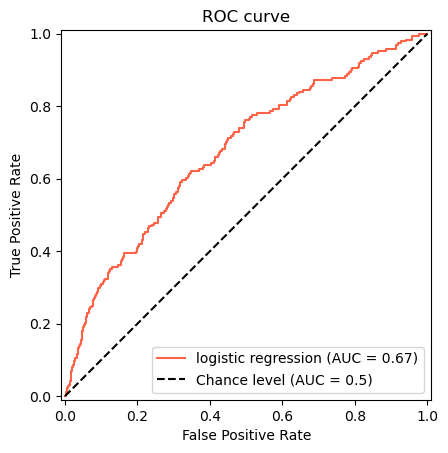

In [43]:
# Affichage de la courbe ROC
lr_RocCurve = RocCurveDisplay.from_predictions(y_test, y_test_proba_lr, name="logistic regression", color="tomato", plot_chance_level=True,)
lr_RocCurve.ax_.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title="ROC curve")
plt.show()

### Log to ML Flow

In [45]:
# In a prompt :
# cd 'C:\Applications\Git\OC-DataScientist-P7\project\mlflow>'
# mlflow ui --port 5050

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://localhost:5050")

# Create a new MLflow Experiment
#mlflow.delete_experiment(895810586240779389)
experiment_name = "OC-DataScientist-P7"
mlflow.set_experiment(experiment_name)


2024/05/16 10:08:52 INFO mlflow.tracking.fluent: Experiment with name 'OC-DataScientist-P7' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/804511157768055429', creation_time=1715846932198, experiment_id='804511157768055429', last_update_time=1715846932198, lifecycle_stage='active', name='OC-DataScientist-P7', tags={}>

In [46]:
# Start an MLflow run
with mlflow.start_run(description="Modèle de base"):
    # Log the hyperparameters
    params = pipe.get_params(deep=False)
    params['custom_threshold_for_classif'] = custom_threshold
    params['smote_sampling_strategy'] = smote_sampling_strategy
    params['undersampling_strategy'] = undersampling_strategy
    mlflow.log_params(params)

    # Log the model metrics (from test results)
    mlflow.log_metrics({"accuracy":accuracy, "roc_auc":roc_auc, "bank_loss":bank_loss})

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tags({
        "Model type" : "Logistic regression",
        "Nb of lines" : "10k",
        "Rebalancing method" : "Smote + undersampling",
        "Feature selection" : "None"})

    # Infer the model signature
    signature = infer_signature(X_train_bal, pipe.predict(X_train_bal))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=pipe,
        artifact_path="Kaggle Kernel with simple features (Aguiar)",
        signature=signature,
        input_example=X_train_bal,
        registered_model_name= experiment_name + "__" + "logistic-regression",
    )

C:\Applications\Anaconda\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'OC-DataScientist-P7__logistic-regression'.
2024/05/16 10:09:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: OC-DataScientist-P7__logistic-regression, version 1
Created version '1' of model 'OC-DataScientist-P7__logistic-regression'.


### Features importance (SHAP) 

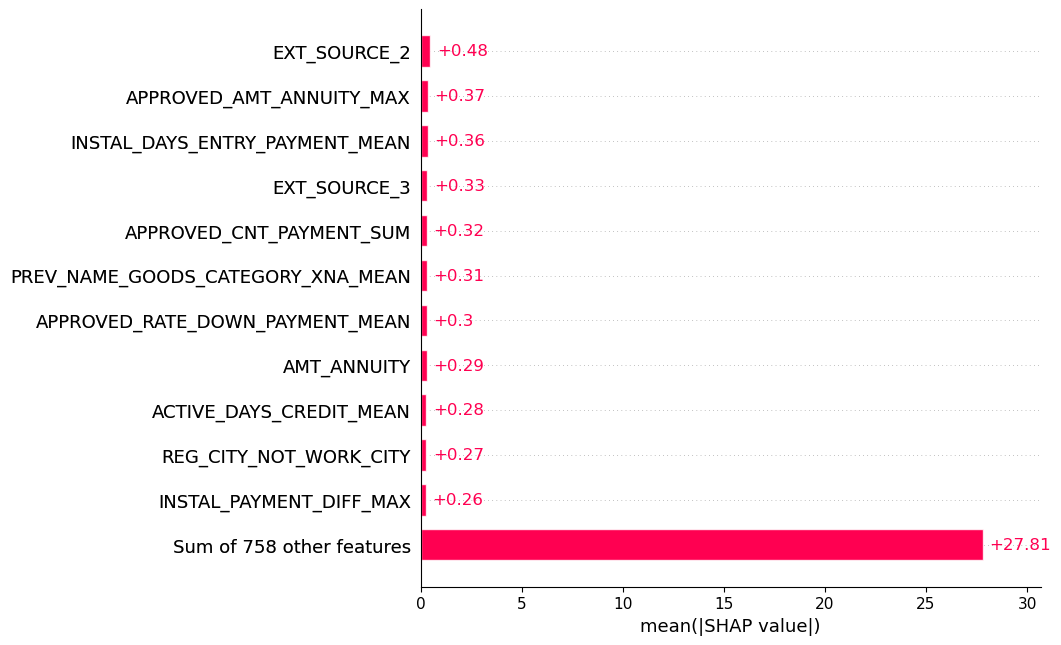

In [47]:
# split the pipeline in individual steps
imputer = pipe.named_steps['imputer']
scaler = pipe.named_steps['scaler']
clf = pipe.named_steps['clf']

# get standardized data
X_scaled = scaler.fit_transform(imputer.fit_transform(X_test_enc))

# explain the model's predictions using SHAP
explainer = shap.LinearExplainer(clf, X_scaled, feature_names=X_test_enc.columns)
shap_values = explainer(X_scaled)

# we convert back to the original data
# (note we can do this because X_std is a set of univariate transformations of X)
shap_values.data = X_test_enc.values

# Summary of features importance
shap.plots.bar(shap_values, max_display=12)

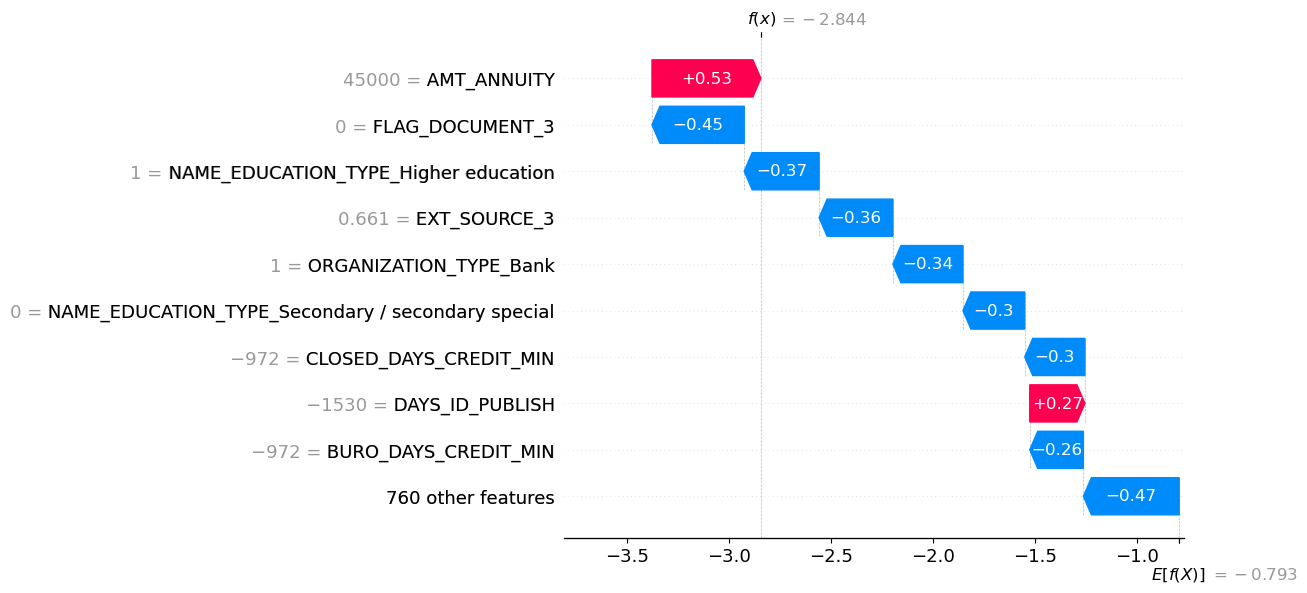

In [48]:
# Explain the score for a single customer
shap.plots.waterfall(shap_values[85])

## Modèle n°2 : Random Forest

In [49]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=None, class_weight='balanced')

### Entraînement du modèle

#### Optimisation des paramètres

In [50]:
# grille de paramètres
#param_grid = {'n_estimators' : [10, 50, 100, 300, 1000]} # Number of trees -> best = 1000
rfc_grid = {'n_estimators' : [1000]}

# initialiser la validation croisée
rfc_search = GridSearchCV(rfc, rfc_grid, cv=5, scoring=bank_score)

# On entraîne ce modèle sur les données d'entrainement
rfc_search.fit(X_train_bal, y_train_bal)

# On extrait la meilleure combinaison de paramètres
res = pd.DataFrame(rfc_search.cv_results_)[['param_n_estimators', 'mean_test_score', 'std_test_score', 'rank_test_score', 'mean_fit_time']]
res.sort_values('rank_test_score').head(10)

,param_n_estimators,mean_test_score,std_test_score,rank_test_score,mean_fit_time
0,1000,-1298.0,735.843733,1,18.100588


#### Fit

In [51]:
# Le modèle est entraîné sur les données équilibrées
rfc.set_params(**rfc_search.best_params_).fit(X_train_bal, y_train_bal)

RandomForestClassifier(class_weight='balanced', n_estimators=1000)

In [52]:
# Le modèle est entraîné sur les données équilibrées
rfc.fit(X_train_bal, y_train_bal)

RandomForestClassifier(class_weight='balanced', n_estimators=1000)

#### Optimisation du seuil

In [53]:
# Les prédictions à partir desquelles on va chercher le seuil optimum sont faites à partir des données déséquilibrées
y_train_proba = rfc.predict_proba(X_train_enc)[:, 1]

In [54]:
custom_threshold = custom_threshold_func(y_train, y_train_proba)

custom threshold : 0.51


### Test results

In [55]:
# Calcul des scores de classification
y_test_proba_rf = rfc.predict_proba(X_test_enc)[:, 1]

# Indicateurs de performances
accuracy, roc_auc, bank_loss = evaluer(y_test, y_test_proba_rf, custom_threshold, True)

accuracy : 0.92
roc_auc : 0.73
bank_loss : 1844

Matrice de confusion :
[[2308    4]
 [ 184    4]]


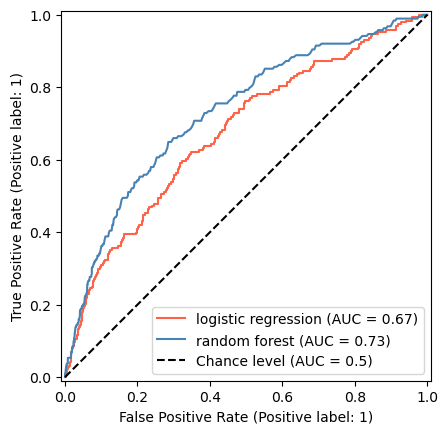

In [56]:
lr_RocCurve.plot(color="tomato")
rf_RocCurve = RocCurveDisplay.from_predictions(y_test, y_test_proba_rf, name="random forest", color="steelblue", ls="-", ax=lr_RocCurve.ax_, plot_chance_level=True)
plt.show()

### Log to ML Flow

In [57]:
# Start an MLflow run
with mlflow.start_run(description="Modèle évolué : Random Forest"):
    # Log the hyperparameters
    params = rfc.get_params(deep=False)
    params['custom_threshold_for_classif'] = custom_threshold
    params['smote_sampling_strategy'] = smote_sampling_strategy
    params['undersampling_strategy'] = undersampling_strategy
    mlflow.log_params(params)

    # Log the model metrics (from test results)
    mlflow.log_metrics({"accuracy":accuracy, "roc_auc":roc_auc, "bank_loss":bank_loss})

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tags({
        "Model type" : "Random Forest",
        "Nb of lines" : "10k",
        "Rebalancing method" : "Smote + undersampling",
        "Feature selection" : "None"})

    # Infer the model signature
    signature = infer_signature(X_train_bal, rfc.predict(X_train_bal))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=rfc,
        artifact_path="Kaggle Kernel with simple features (Aguiar)",
        signature=signature,
        input_example=X_train_bal,
        registered_model_name= experiment_name + "__" + "random-forest",
    )

Successfully registered model 'OC-DataScientist-P7__random-forest'.
2024/05/16 10:13:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: OC-DataScientist-P7__random-forest, version 1
Created version '1' of model 'OC-DataScientist-P7__random-forest'.


### Features importance

#### From SHAP

In [58]:
explainer = shap.TreeExplainer(rfc, X_test_enc, feature_names=X_test_enc.columns, model_output='probability')
shap_values = explainer(X_test_enc)
shap_values.shape

100%|===================| 4998/5000 [14:02<00:00]        

(2500, 769, 2)

In [61]:
# Summary of features importance
shap.plots.bar(shap_values, max_display=12)

IndexError: list index out of range

#### From Random Forest model itself

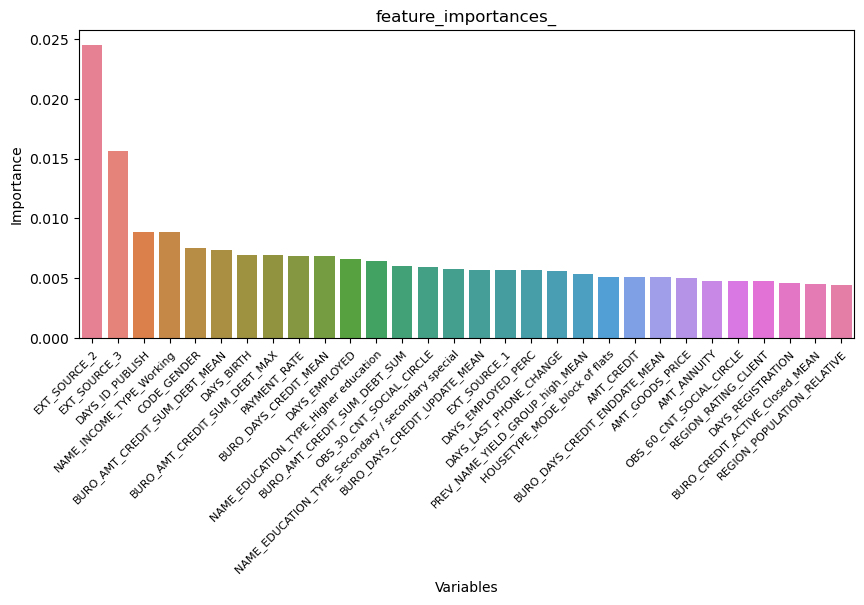

In [62]:
res = pd.DataFrame(zip(rfc.feature_names_in_, rfc.feature_importances_))
res.columns = ['Variables', 'Importance']
res.sort_values('Importance', ascending = False, inplace=True)
fig = plt.figure(figsize = (10, 4))
sns.barplot(data = res[:30], x = 'Variables', y = 'Importance', palette = 'husl')
plt.xticks(rotation=45, ha = 'right', rotation_mode="anchor", size=8)
plt.title('feature_importances_')
plt.show()

## Modèle n°3 : Gradient Boosting

In [63]:
def bank_loss_feval(preds, dataset):
    """Calculate Bank loss"""
    labels = dataset.get_label()
    tn, fp, fn, tp = confusion_matrix(labels, preds > 0.5).ravel()
    bk_loss = 10*fn + fp # un crédit accordé non remboursé est évalué à un montant 10 fois plus élevé qu'un crédit solvable non accordé
    
    # # eval_name, eval_result, is_higher_better
    return 'bank_loss', bk_loss, False

In [64]:
def objective(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']

    # Fixed parameters (and different from default values)
    hyperparameters['is_unbalance'] = True
    hyperparameters['objective'] = 'binary'
    hyperparameters['metric'] = 'bank_loss' # no way to early-stop based on bank_loss only if we specify other metrics here
    hyperparameters['feature_pre_filter'] = False
    hyperparameters['silent'] = -1
    hyperparameters['verbose'] = -1
    
    # Call back for early stopping
    early_stopping_cb = [lgb.early_stopping(stopping_rounds=30)]
    # early_stopping_cb = [lgb.early_stopping(stopping_rounds=30), lgb.log_evaluation(period=1, show_stdv=False)]
    
    # cv() only accepts Dataset object and it must be recreated in order to change <subsample_for_bin>'s value.
    train_set = lgb.Dataset(data=X_train_bal_renamed, label=y_train_bal)

    # Cross validation with early stopping
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, feval=bank_loss_feval, nfold=5, seed = 1209, callbacks=early_stopping_cb)
    
    # results to return
    score = cv_results['valid bank_loss-mean'][-1]
    estimators = len(cv_results['valid bank_loss-mean'])
    hyperparameters['n_estimators'] = estimators 

    del train_set, cv_results
    gc.collect()
    
    return [score, hyperparameters, iteration]

In [65]:
def random_search(param_grid, out_file, max_evals):
    """Random search for hyperparameter optimization"""
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'], index = list(range(max_evals)))
    
    # Keep searching until reach max evaluations
    for i in range(max_evals):
        print(f">>>>> EVAL n° {i} <<<<<")
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()} # Choose random hyperparameters

        
        eval_results = objective(hyperparameters, i) # Evaluate randomly selected hyperparameters
        results.loc[i, :] = eval_results

        # open connection (append option) and write results
        of_connection = open(out_file, 'a', newline='')
        writer = csv.writer(of_connection)
        writer.writerow(eval_results)
        # make sure to close connection
        of_connection.close()
        
    # Sort with lowest score on top
    results.sort_values('score', ascending = True, inplace = True)
    results.reset_index(inplace = True, drop=True)
    return results 

In [66]:
def grid_search(param_grid, out_file, start_eval, stop_eval):
    """Grid search algorithm (with limit on max evals)"""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'], index = list(range(stop_eval-start_eval)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())
    
    i = 0
    # Iterate through every possible combination of hyperparameters
    all_combinations = list(itertools.product(*values))
    searched_combinations = all_combinations[start_eval:stop_eval]
    
    for v in searched_combinations:
        print(f">>>>> EVAL n° {i} <<<<<")
        
        # Create a hyperparameter dictionary
        hyperparameters = dict(zip(keys, v))

        # Evalute the hyperparameters
        eval_results = objective(hyperparameters, i)       
        results.loc[i, :] = eval_results

        # open connection (append option) and write results
        of_connection = open(out_file, 'a', newline='')
        writer = csv.writer(of_connection)
        writer.writerow(eval_results)
        # make sure to close connection
        of_connection.close()
        
        i += 1
       
    # Sort with lowest score on top
    results.sort_values('score', ascending = True, inplace = True)
    results.reset_index(inplace = True, drop=True)
    
    return results 

In [67]:
def top_N_params(params_grid, results_grid, N=10):
    """ Display the TOP-N parameters set according to results grid """
    # best params sets
    top_N_params = pd.DataFrame(columns = params_grid.keys(), index=range(N))
    for r in range(N) : # r = result index
        for i, p in enumerate(params_grid.keys()) : # p = parameter index
           top_N_params.iloc[r, i] = results_grid['hyperparameters'][r][p]

    # add the score columns
    top_N_params['score'] = results_grid.iloc[:N, 0]
    return top_N_params

### Entraînement du modèle

In [68]:
# Remove special JSON characters from columns name
new_cols = []
for col_name in X_train_bal.columns : new_cols.append(''.join(letter for letter in col_name if (letter.isalnum() or letter=='_')))
X_train_bal_renamed = X_train_bal.copy()
X_train_bal_renamed.columns = new_cols

In [69]:
# Liste complète des paramètres dont ceux adaptés à notre étude :
lgbm = lgb.LGBMClassifier(class_weight='balanced', is_unbalance=True, objective='binary', metrics=['auc', 'binary_error'], feature_pre_filter=False, silent=-1, verbose=-1,)
basic_params = lgbm.get_params()
basic_params

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'is_unbalance': True,
 'metrics': ['auc', 'binary_error'],
 'feature_pre_filter': False,
 'silent': -1,
 'verbose': -1}

In [70]:
temps_init = time.time()
test_basique = objective(basic_params, 0) # Evaluate randomly selected hyperparameters
duree_unitaire = round(time.time()-temps_init, 1)
print(f"\nDurée d'un round limité par l'early stopping : {duree_unitaire} secondes")

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[32]	cv_agg's valid bank_loss: 728.4 + 38.1817

Durée d'un round limité par l'early stopping : 6.1 secondes


#### Optimisation des paramètres : Random Search

In [71]:
# Hyperparameter grid
random_params = {
    'num_leaves': list(range(20, 60, 5)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 10)),
    'subsample_for_bin': [10000, 50000, 200000],
    'min_child_samples': list(range(20, 500, 50)),
    'reg_alpha': list(np.linspace(0, 0.5, 20)),
    'reg_lambda': list(np.linspace(0, 0.5, 20)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.6, 1, 5))
}

In [72]:
# Nb de combinaisons de paramètres :
com = 1
for x in random_params.values():
    com *= len(x)

# Durée d'évaluation d'une combinaires
duree = int(duree_unitaire)

# Réflexion 1 :
print('There are {} combinations'.format(com))
print('If we assume {:2d} seconds per evaluation...'.format(duree))
print('\t... this would take {:2d} years to finish.'.format(int((duree * com) / (60 * 60 * 24 * 365))))

# Réflexion 2 : 
print("Disons qu'on accepte de patienter 1/2 heure...")
print("\t... cela nous permet de tester {:2d} combinaisons.".format(int(30 * 60 / duree)))

There are 48000000 combinations
If we assume  6 seconds per evaluation...
	... this would take  9 years to finish.
Disons qu'on accepte de patienter 1/2 heure...
	... cela nous permet de tester 300 combinaisons.


In [139]:
# Run this cell to launch random search
# #####################################

# Create file + open connection
path_to_results = "../results/random_search_100k/"
out_file = path_to_results + 'Trials_10K_150D.csv'
of_connection = open(out_file, 'w', newline='')
writer = csv.writer(of_connection)

# Write column names
headers = ['score', 'hyperparameters', 'iteration']
writer.writerow(headers)
of_connection.close()

# Launch random search
MAX_EVALS = 150
random_results = random_search(random_params, out_file, MAX_EVALS)

>>>>> EVAL n° 0 <<<<<
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[286]	cv_agg's valid bank_loss: 6943.6 + 214.886
>>>>> EVAL n° 1 <<<<<
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	cv_agg's valid bank_loss: 20668 + 4
>>>>> EVAL n° 2 <<<<<
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[47]	cv_agg's valid bank_loss: 7050.4 + 236.197
>>>>> EVAL n° 3 <<<<<
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[123]	cv_agg's valid bank_loss: 6892.8 + 136.861
>>>>> EVAL n° 4 <<<<<
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[57]	cv_agg's valid bank_loss: 7083.2 + 192.06
>>>>> EVAL n° 5 <<<<<
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[459]	cv_agg's valid bank_loss: 6859.4 + 201.61
>>>>> EVAL 

In [74]:
# Run this cell to load previous results from random search
# #########################################################
path_to_results = "../results/random_search_100k/"
random_results = pd.DataFrame(columns = ['score', 'hyperparameters', 'iteration'])

# concatenate all available results
for file in os.listdir(path_to_results) :
    file_results = pd.read_csv(path_to_results + file)
    random_results = pd.concat( [random_results, file_results], ignore_index = True )

random_results.pop("iteration")

# Convert strings to dictionaries (when we save the results to a csv, for some reason the dictionaries are saved as strings...)
random_results['hyperparameters'] = random_results['hyperparameters'].map(ast.literal_eval)

# Sort with lowest score on top
random_results.sort_values('score', ascending = True, inplace = True)
random_results.reset_index(inplace = True, drop=True)

In [75]:
# Display top-N parameters sets
random_top = top_N_params(random_params, random_results, 20)
random_top

,num_leaves,learning_rate,subsample_for_bin,min_child_samples,reg_alpha,reg_lambda,colsample_bytree,subsample,score
0,20,0.038713,200000,420,0.157895,0.947368,0.688889,0.5,6736.6
1,20,0.064577,10000,370,0.578947,0.105263,0.822222,0.555556,6768.2
2,20,0.023208,10000,470,0.315789,0.394737,0.777778,0.6,6777.8
3,20,0.064577,50000,470,0.210526,0.5,0.733333,0.6,6779.0
4,35,0.064577,50000,420,0.447368,0.078947,0.955556,0.8,6781.6
5,25,0.038713,10000,470,0.078947,0.394737,0.866667,1.0,6785.4
6,20,0.038713,200000,370,0.684211,0.684211,0.866667,0.944444,6790.0
7,30,0.107722,50000,470,0.026316,0.236842,0.911111,0.8,6795.8
8,20,0.023208,200000,370,0.289474,0.447368,0.777778,0.8,6797.6
9,20,0.038713,10000,420,0.157895,0.026316,0.911111,0.8,6799.0


#### Optimisation des paramètres : Grid Search

In [76]:
# More precised hyperparameter grid : => 250 combinations
grid_params = {
    'num_leaves': [20],
    'learning_rate': list(np.linspace(0.03, 0.10, 5)),
    'subsample_for_bin': [200000],
    'min_child_samples': [370],
    'reg_alpha': list(np.linspace(0.5, 0.7, 5)),
    'reg_lambda': list(np.linspace(0.7, 1, 5)),
    'colsample_bytree': [0.8],
    'subsample': [0.75, 0.9]
}

In [59]:
# Run this cell to launch random search
# #####################################

# Create file + open connection
path_to_results = "../results/grid_search_100k/"
out_file = path_to_results + 'Trials_xxxyyyC.csv'
of_connection = open(out_file, 'w', newline='')
writer = csv.writer(of_connection)

# Write column names
headers = ['score', 'hyperparameters', 'iteration']
writer.writerow(headers)
of_connection.close()

# Launch grid search
START_EVAL = 0
STOP_EVAL = 0

grid_results = grid_search(grid_params, out_file, START_EVAL, STOP_EVAL)

>>>>> EVAL n° 0 <<<<<
[LightGBM] [Info] Number of positive: 8267, number of negative: 25052
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138439
[LightGBM] [Info] Number of data points in the train set: 33319, number of used features: 758
[LightGBM] [Info] Number of positive: 8267, number of negative: 25052
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138439
[LightGBM] [Info] Number of data points in the train set: 33319, number of used features: 758
[LightGBM] [Info] Number of positive: 8267, number of negative: 25052
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tota

In [77]:
# Run this cell to load previous results from grid search
# #########################################################
path_to_results = "../results/grid_search_100k/"
grid_results = pd.DataFrame(columns = ['score', 'hyperparameters', 'iteration'])

# concatenate all available results
for file in os.listdir(path_to_results) :
    file_results = pd.read_csv(path_to_results + file)
    grid_results = pd.concat( [grid_results, file_results], ignore_index = True )

grid_results.pop("iteration")

# Convert strings to dictionaries (when we save the results to a csv, for some reason the dictionaries are saved as strings...)
grid_results['hyperparameters'] = grid_results['hyperparameters'].map(ast.literal_eval)

# Sort with lowest score on top
grid_results.sort_values('score', ascending = True, inplace = True)
grid_results.reset_index(inplace = True, drop=True)

In [78]:
# Display top-N parameters sets
grid_top = top_N_params(grid_params, grid_results, 15)
grid_top

,num_leaves,learning_rate,subsample_for_bin,min_child_samples,reg_alpha,reg_lambda,colsample_bytree,subsample,score
0,20,0.1,200000,370,0.633333,0.85,0.8,0.6,6743.8
1,20,0.03,200000,370,0.65,0.775,0.8,0.75,6748.2
2,20,0.0475,200000,370,0.5,0.925,0.8,0.75,6748.2
3,20,0.0475,200000,370,0.5,0.925,0.8,0.9,6748.2
4,20,0.03,200000,370,0.65,0.775,0.8,0.9,6748.2
5,20,0.0475,200000,370,0.5,0.925,0.8,0.6,6748.2
6,20,0.1,200000,370,0.6,0.925,0.8,0.75,6756.2
7,20,0.1,200000,370,0.6,0.925,0.8,0.9,6756.2
8,20,0.03,200000,370,0.5,0.775,0.8,0.75,6756.8
9,20,0.03,200000,370,0.5,0.775,0.8,0.9,6756.8


#### Fit

In [79]:
# Best params found from grid search
test_params = grid_results.loc[0, 'hyperparameters']
# + fixed params as in grid search
test_params['is_unbalance'] = True
test_params['objective'] = 'binary'
test_params['metrics'] = 'bank_loss'

print("Parameters set used for test data :")
pprint.pprint(test_params)

Parameters set used for test data :
{'colsample_bytree': 0.8,
 'feature_pre_filter': False,
 'is_unbalance': True,
 'learning_rate': 0.1,
 'metric': 'bank_loss',
 'metrics': 'bank_loss',
 'min_child_samples': 370,
 'n_estimators': 77,
 'num_leaves': 20,
 'objective': 'binary',
 'reg_alpha': 0.6333333333333333,
 'reg_lambda': 0.85,
 'subsample': 0.6,
 'subsample_for_bin': 200000}


In [40]:
test_params = {
    'colsample_bytree': 0.8,
    'feature_pre_filter': False,
    'is_unbalance': True,
    'learning_rate': 0.1,
    'metric': 'bank_loss',
    'metrics': 'bank_loss',
    'min_child_samples': 370,
    'n_estimators': 77,
    'num_leaves': 20,
    'objective': 'binary',
    'reg_alpha': 0.6333333333333333,
    'reg_lambda': 0.85,
    'subsample': 0.6,
    'subsample_for_bin': 200000
}

In [81]:
temps_init = time.time()
# Implement an lgbm model
lgbm = lgb.LGBMClassifier(**test_params, random_state=1209, silent=-1, verbose=-1,)

# Fit
lgbm.fit(X_train_bal_renamed, y_train_bal)

duree_modelisation = round(time.time()-temps_init, 1)
print(f"\nDurée d'entraînement du modèle LightGBM avec hyperparamètres optimisés : {duree_modelisation} secondes")


Durée d'entraînement du modèle LightGBM avec hyperparamètres optimisés : 0.4 secondes


#### Optimisation du seuil

In [82]:
# Les prédictions à partir desquelles on va chercher le seuil optimum sont faites à partir des données déséquilibrées
y_train_proba = lgbm.predict_proba(X_train_enc)[:, 1]

In [83]:
custom_threshold = custom_threshold_func(y_train, y_train_proba)

custom threshold : 0.48


### Test results

In [84]:
temps_init = time.time()
# Calcul des scores de classification
y_test_proba_lgbm = lgbm.predict_proba(X_test_enc)[:, 1]

# Indicateurs de performances
accuracy, roc_auc, bank_loss = evaluer(y_test, y_test_proba_lgbm, custom_threshold, True)

duree_modelisation = round(time.time()-temps_init, 1)
print(f"\nDurée de prédiction par le modèle LightGBM avec hyperparamètres optimisés : {duree_modelisation} secondes")

accuracy : 0.77
roc_auc : 0.74
bank_loss : 1391

Matrice de confusion :
[[1841  471]
 [  92   96]]

Durée de prédiction par le modèle LightGBM avec hyperparamètres optimisés : 0.0 secondes


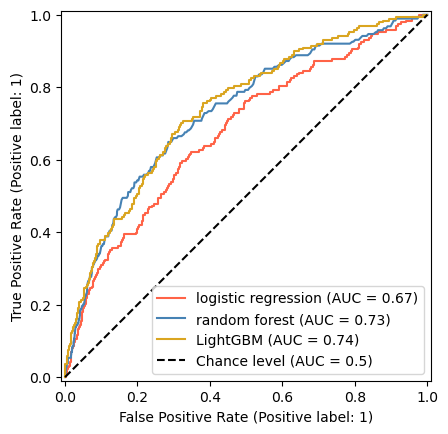

In [85]:
lr_RocCurve.plot(color="tomato")
rf_RocCurve = RocCurveDisplay.from_predictions(y_test, y_test_proba_rf, name="random forest", color="steelblue", ls="-", ax=lr_RocCurve.ax_)
lgbm_RocCurve = RocCurveDisplay.from_predictions(y_test, y_test_proba_lgbm, name="LightGBM", color="goldenrod", ls="-", ax=lr_RocCurve.ax_, plot_chance_level=True)
plt.show()

### Log to ML Flow

In [86]:
# Start an MLflow run
with mlflow.start_run(description="Modèle évolué : LightGBM"):
    # Log the hyperparameters
    params = lgbm.get_params(deep=False)
    params['custom_threshold_for_classif'] = custom_threshold
    params['smote_sampling_strategy'] = smote_sampling_strategy
    params['undersampling_strategy'] = undersampling_strategy
    mlflow.log_params(params)

    # Log the model metrics (from test results)
    mlflow.log_metrics({"accuracy":accuracy, "roc_auc":roc_auc, "bank_loss":bank_loss})

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tags({
        "Model type" : "Gradient Boosting",
        "Nb of lines" : "10k",
        "Rebalancing method" : "Smote + undersampling",
        "Feature selection" : "None"})

    # Infer the model signature
    signature = infer_signature(X_train_bal, lgbm.predict(X_train_bal))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=lgbm,
        artifact_path="Kaggle Kernel with simple features (Aguiar)",
        signature=signature,
        input_example=X_train_bal,
        registered_model_name= experiment_name + "__" + "lightgbm",
    )

Successfully registered model 'OC-DataScientist-P7__lightgbm'.
2024/05/16 10:34:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: OC-DataScientist-P7__lightgbm, version 1
Created version '1' of model 'OC-DataScientist-P7__lightgbm'.


### Features importance

#### From SHAP

In [95]:
explainer = shap.TreeExplainer(lgbm, X_test_enc, feature_names=X_test_enc.columns, model_output='probability')
shap_values = explainer(X_test_enc)
shap_values.shape

 99%|===================| 24785/25000 [00:59<00:00]        

(25000, 792)

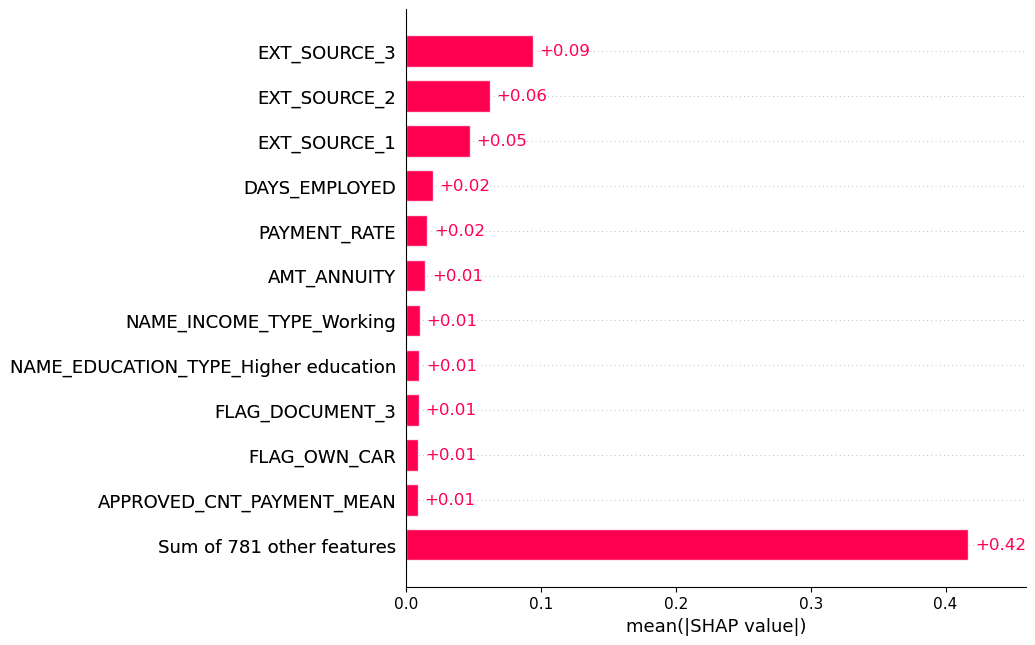

In [96]:
# Summary of features importance
shap.plots.bar(shap_values, max_display=12)

#### From LightGBM model itself

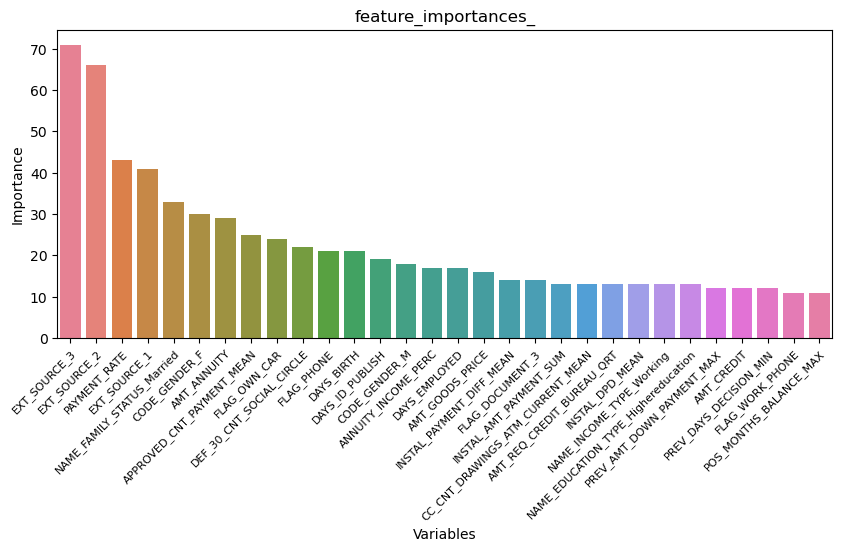

In [57]:
res = pd.DataFrame(zip(lgbm.feature_name_, lgbm.feature_importances_))
res.columns = ['Variables', 'Importance']
res.sort_values('Importance', ascending = False, inplace=True)
fig = plt.figure(figsize = (10, 4))
sns.barplot(data = res[:30], x = 'Variables', y = 'Importance', palette = 'husl')
plt.xticks(rotation=45, ha = 'right', rotation_mode="anchor", size=8)
plt.title('feature_importances_')
plt.show()

In [78]:
N_features = 8
top_features = res[:N_features]['Variables'].values
top_features

array(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'PAYMENT_RATE', 'EXT_SOURCE_1',
       'NAME_FAMILY_STATUS_Married', 'CODE_GENDER_F', 'AMT_ANNUITY',
       'APPROVED_CNT_PAYMENT_MEAN'], dtype=object)

# Submission File

## Assembling Submission Data ("Kaggle Test")

In [82]:
# load Min file
nombre_de_lignes = None
app_kaggle_test = main_file('test', nombre_de_lignes)

Tailles des données d'origine : (48744, 121)
Tailles des données avec features ajoutées : (48744, 126)


In [83]:
# Encodage
X_sub_enc = encodeur(app_kaggle_test)

Tailles des données avant encodage des variables catégorielles : (48744, 126)
Tailles des données après encodage des variables catégorielles : (48744, 247)


In [84]:
## Add features from secondary files
X_sub_enc = add_variables(X_sub_enc)

Tailles des données avant enrichissement : (48744, 247)
------------------------------------------
bureau.csv & bureau_balance.csv - Tailles des données chargées : (42320, 113)
bureau.csv & bureau_balance.csv - Traité en 11s
previous_applications.csv - Tailles des données chargées : (47800, 248)
previous_applications - Traité en 7s
POS_CASH_balance.csv - Tailles des données chargées : (47808, 17)
POS_CASH_balance.csv - Traité en 6s
installments_payments.csv - Tailles des données chargées : (47944, 26)
installments_payments.csv - Traité en 11s
credit_card_balance.csv - Tailles des données chargées : (16653, 136)
credit_card_balance.csv - Traité en 7s
------------------------------------------
Tailles des données après enrichissement : (48744, 787)


In [85]:
# Alignement des colonnes de X_sub sur X_train
X_sub_enc = aligner(X_sub_enc, X_train_enc)
X_sub_enc.sort_index(axis=1, inplace=True)
X_sub_enc.shape

(48744, 792)

## Create submission file

In [94]:
# Make the submission dataframe
test_ids = X_sub_enc['SK_ID_CURR']
test_predictions = lgbm.predict_proba(X_sub_enc)[:, 1]
sub = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
sub.head()

# Export
path_to_sub = "../submission_files/"
file_name = "lgbm_100k.csv"
sub.to_csv(path_to_sub + file_name, index = False)

# Model for API

## Re-train

In [127]:
# Use only the most important features
X_train_api_bal = X_train_bal[top_features]
y_train_api_bal = y_train_bal
X_test_api = X_test_enc[top_features]
y_test_api = y_test

# Let's use our Logistic Regression Model for the API
model_api = pipe

# Fit
model_api.fit(X_api_bal, y_api_bal)

# Predict
y_test_proba_api = model_api.predict_proba(X_test_api)[:, 1]

# Indicateurs de performances
accuracy, roc_auc, bank_loss = evaluer(y_test_api, y_test_proba_api, 0.5, True)

accuracy : 0.61
roc_auc : 0.72
bank_loss : 14914

Matrice de confusion :
[[13936  9074]
 [  584  1406]]


## Dump model

In [133]:
path_to_model = "../../models/"
model_name = 'lr-pipe_8feat.joblib'
joblib.dump(model_api, path_to_model + model_name)

['../Models/lr-pipe_8feat.joblib']

In [91]:
# Check if loads correctly
path_to_model = "../../models/"
model_name = 'lr-pipe_8feat.joblib'
model_load = joblib.load(path_to_model + model_name)

y_test_proba_load = model_load.predict_proba(X_test_api)[:, 1]

# Indicateurs de performances
accuracy, roc_auc, bank_loss = evaluer(y_test_api, y_test_proba_load, 0.5, True)

NameError: name 'X_test_api' is not defined

In [93]:
print(model_load[0])

SimpleImputer(strategy='median')


# Fin

In [87]:
print(joblib.__version__)

1.2.0


In [89]:
import flask
print(flask.__version__)

2.2.5


In [ ]:
print(flask.__version__)